In [1]:
project_desc = """
Project: Fake News Detection & Analysis in Real Time

Description:
> This project focuses on analyzing news articles to detect fake and true news. 
> It includes data cleaning, exploratory data analysis (EDA), feature extraction, 
and preparation for machine learning modeling. The workflow covers:

- Text preprocessing (cleaning, lemmatization, stopword removal)
- Statistical and visual analysis of news content
- Extraction of key text features (word count, character count, sentiment polarity)
- Identification of frequent words, bigrams, and trigrams
- Preparation for training predictive models to classify news as Fake or True

Source: https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets/data
(kaggle)
"""

print(project_desc)


Project: Fake News Detection & Analysis in Real Time

Description:
> This project focuses on analyzing news articles to detect fake and true news. 
> It includes data cleaning, exploratory data analysis (EDA), feature extraction, 
and preparation for machine learning modeling. The workflow covers:

- Text preprocessing (cleaning, lemmatization, stopword removal)
- Statistical and visual analysis of news content
- Extraction of key text features (word count, character count, sentiment polarity)
- Identification of frequent words, bigrams, and trigrams
- Preparation for training predictive models to classify news as Fake or True

Source: https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets/data
(kaggle)



Dataset shape: (44898, 5)
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  label  
0  December 31, 2017       1  
1  December 29, 2017       1  
2  December 31, 2017       1  
3  December 30, 2017       1  
4  December 29, 2017       1  
Cleaned data and saved to CSV.

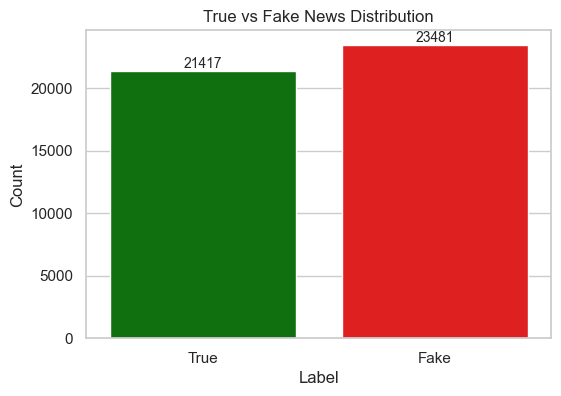

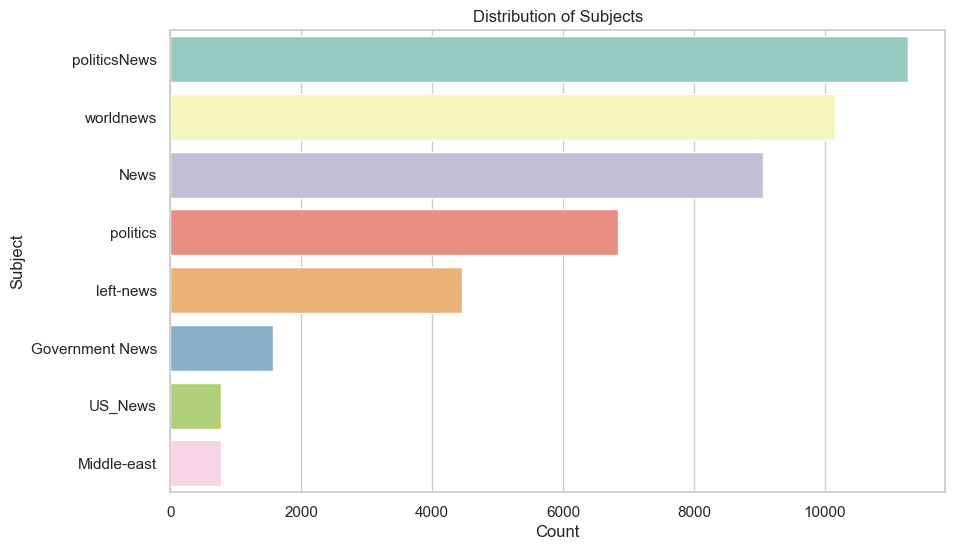

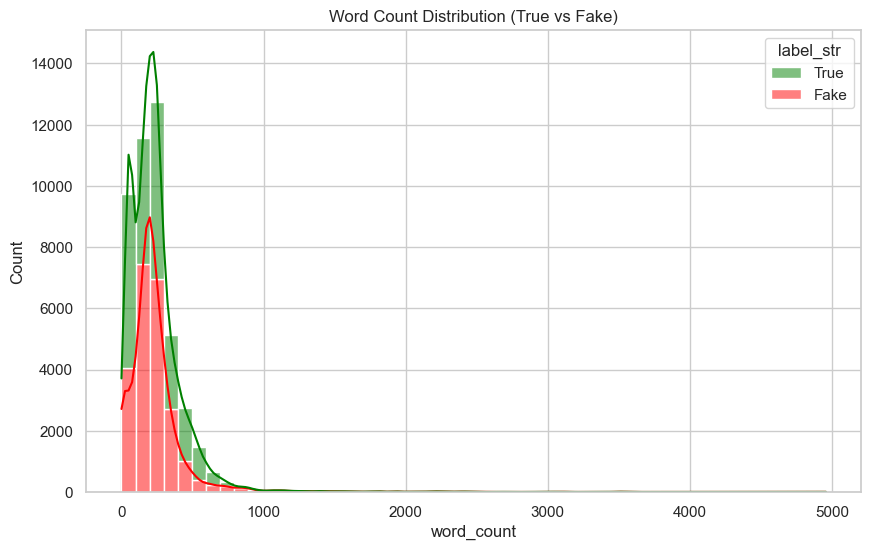

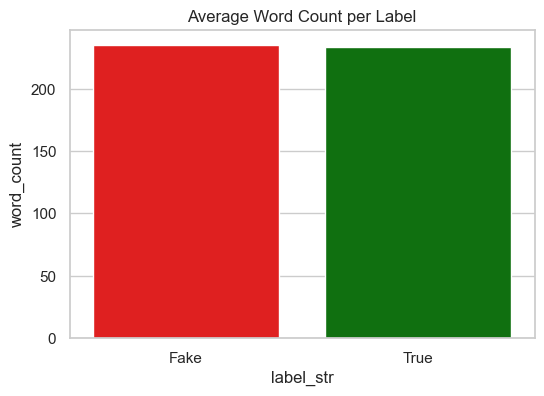

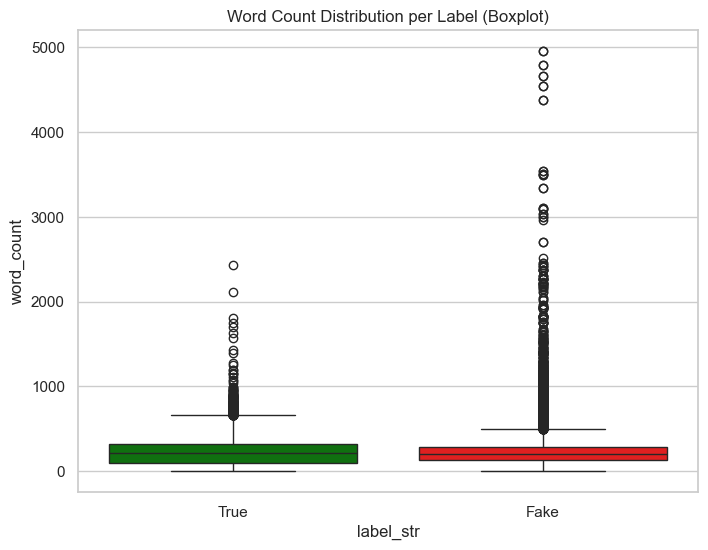

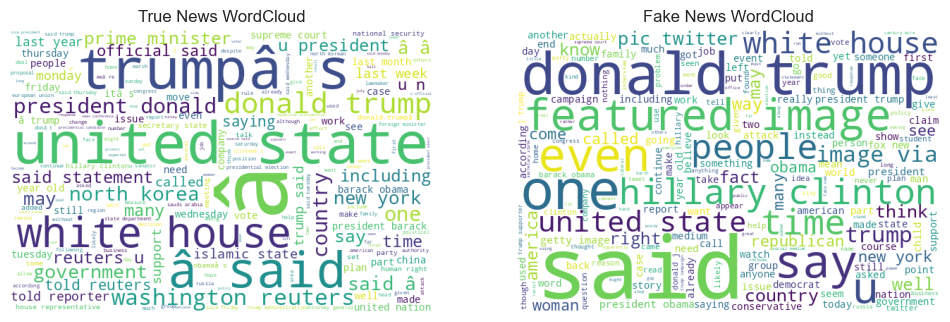

Top 20 words in True News:
 [('said', 99035), ('u', 47056), ('trump', 42758), ('â\x80\x9d', 40321), ('state', 36284), ('would', 31509), ('reuters', 28856), ('president', 27655), ('republican', 22696), ('year', 22102), ('government', 19622), ('house', 16867), ('new', 16849), ('also', 15944), ('united', 15580), ('people', 15008), ('election', 14709), ('official', 14573), ('told', 14245), ('party', 14143)]

Top 20 words in Fake News:
 [('trump', 79361), ('said', 33761), ('president', 28270), ('people', 26621), ('one', 25386), ('u', 24408), ('state', 23625), ('would', 23551), ('clinton', 19781), ('time', 19174), ('year', 19047), ('obama', 18750), ('like', 18638), ('american', 18107), ('donald', 17662), ('republican', 16713), ('say', 15777), ('also', 15401), ('right', 14849), ('news', 14612)]


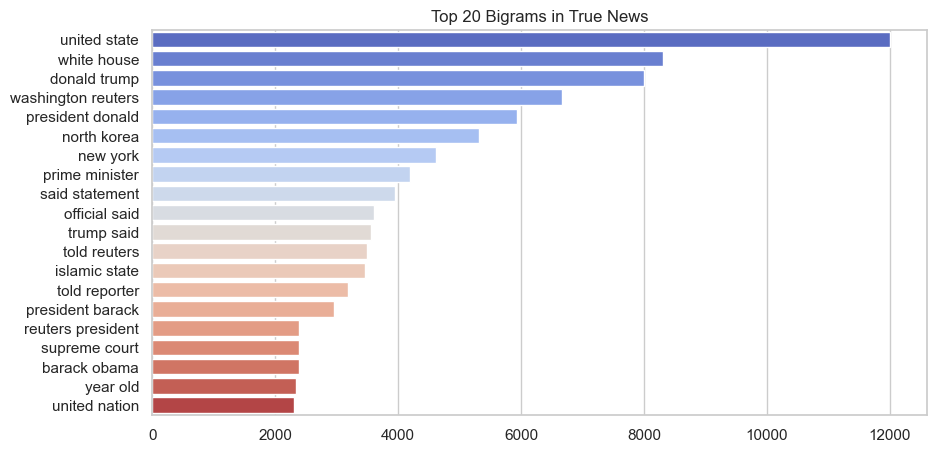

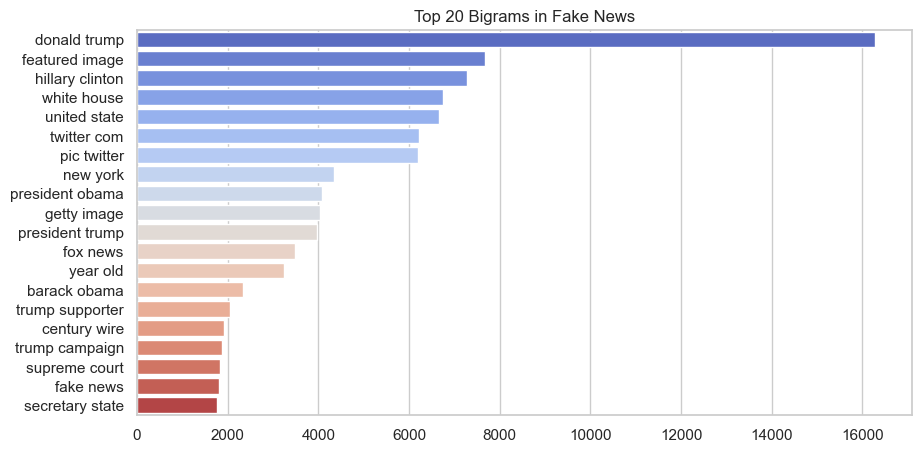

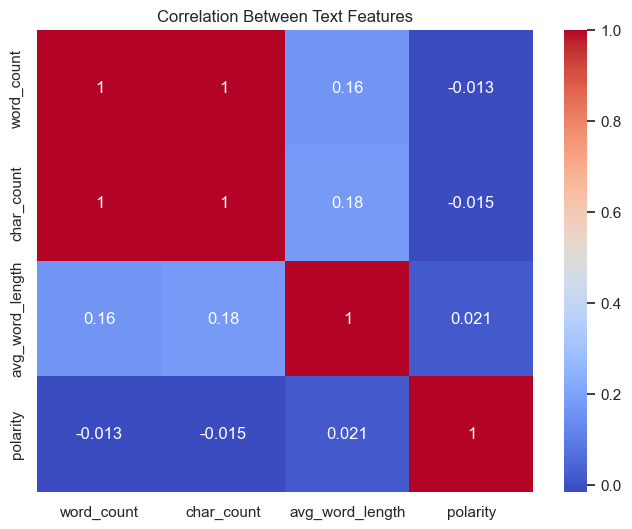

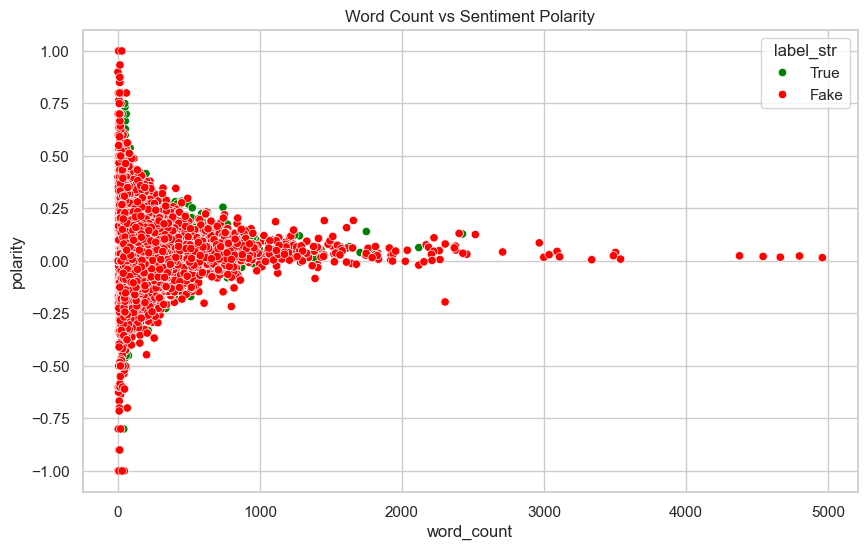

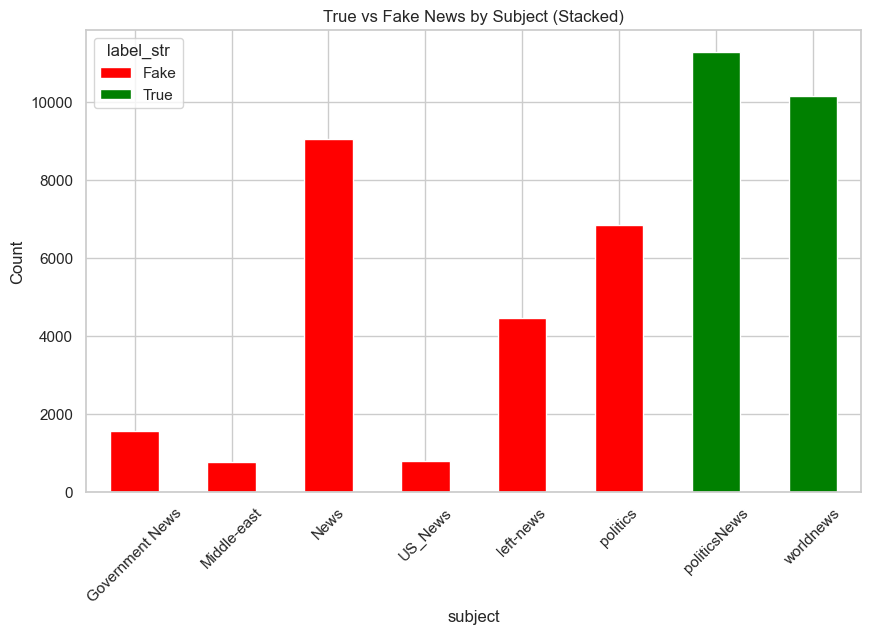

In [ ]:
# importing libraries
import os
import re
import string
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import nltk

# Skip if already donwlaoded
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from textblob import TextBlob

sns.set(style="whitegrid")


# loading datasets
true = pd.read_csv("./datasets/True.csv", encoding="latin1")
fake = pd.read_csv("./datasets/Fake.csv", encoding="latin1")

true["label"] = 1   # True news
fake["label"] = 0   # Fake news

df = pd.concat([true, fake], ignore_index=True)
print("Dataset shape:", df.shape)
print(df.head())


# text cleaning

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"\[.*?\]", "", text)                 # remove [brackets]
    text = re.sub(r"https?://\S+|www\.\S+", "", text)   # remove urls
    text = re.sub(r"<.*?>+", "", text)                  # remove html
    text = re.sub(r"[%s]" % re.escape(string.punctuation), " ", text)  # punctuation
    text = re.sub(r"\n", " ", text)                     # newlines
    text = re.sub(r"\w*\d\w*", "", text)                # words with numbers
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text



dataset = "./datasets/true_and_fake_news_clean.csv"

if os.path.exists(dataset):
    df = pd.read_csv(dataset, encoding="utf-8")
    print("Loaded cleaned data from CSV.")
else:
    df["clean_text"] = df["text"].apply(clean_text)
    df.to_csv(dataset, index=False, encoding="utf-8")
    print("Cleaned data and saved to CSV.")

print(df[["text", "clean_text"]].head())
print(df.isnull().sum())


# EDA
df["label_str"] = df["label"].map({0: "Fake", 1: "True"})
palette_colors = {"Fake": "red", "True": "green"}

# Class distribution
plt.figure(figsize=(6, 4))
ax = sns.countplot(x="label_str", data=df, hue="label_str",palette=palette_colors, dodge=False, legend=False)
plt.title("True vs Fake News Distribution")
plt.xlabel("Label"); plt.ylabel("Count")

for p in ax.patches:
    ax.annotate(str(int(p.get_height())),
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha="center", va="bottom", fontsize=10)
plt.show()

# Subject distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(y="subject", data=df, hue="subject", palette="Set3",
                   order=df["subject"].value_counts().index,
                   dodge=False, legend=False)
plt.title("Distribution of Subjects")
plt.xlabel("Count"); plt.ylabel("Subject")
plt.show()

# Word count
df["word_count"] = df["clean_text"].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="word_count", hue="label_str", bins=50,
             kde=True, multiple="stack", palette=palette_colors)
plt.title("Word Count Distribution (True vs Fake)")
plt.show()

# Average word count per label
avg_word_count = df.groupby("label_str")["word_count"].mean().reset_index()
plt.figure(figsize=(6, 4))
sns.barplot(x="label_str", y="word_count", data=avg_word_count,
            hue="label_str", palette=palette_colors,
            dodge=False, legend=False)
plt.title("Average Word Count per Label")
plt.show()

# Boxplot word count
plt.figure(figsize=(8, 6))
sns.boxplot(x="label_str", y="word_count", data=df,
            hue="label_str", palette=palette_colors,
            dodge=False, legend=False)
plt.title("Word Count Distribution per Label (Boxplot)")
plt.show()


# Features
df["clean_text"] = df["clean_text"].fillna("").astype(str)

# Character count
df["char_count"] = df["clean_text"].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)

# Average word length
df["avg_word_length"] = df["clean_text"].apply(
    lambda x: np.mean([len(w) for w in str(x).split()]) if pd.notnull(x) and len(str(x).split()) > 0 else 0
)

# Sentence count
df["sentence_count"] = df["clean_text"].apply(
    lambda x: len(str(x).split(".")) if pd.notnull(x) else 0
)

# Polarity
df["polarity"] = df["clean_text"].apply(
    lambda x: TextBlob(str(x)).sentiment.polarity if pd.notnull(x) else 0
)

# WordClouds
text_true = " ".join(df[df["label_str"] == "True"]["clean_text"].fillna("").astype(str))
text_fake = " ".join(df[df["label_str"] == "Fake"]["clean_text"].fillna("").astype(str))

wc_true = WordCloud(width=600, height=400, background_color="white").generate(text_true)
wc_fake = WordCloud(width=600, height=400, background_color="white").generate(text_fake)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.imshow(wc_true); plt.axis("off"); plt.title("True News WordCloud")
plt.subplot(1, 2, 2); plt.imshow(wc_fake); plt.axis("off"); plt.title("Fake News WordCloud")
plt.show()

# Top words
def get_top_words(texts, n=20):
    words = " ".join(texts).split()
    return Counter(words).most_common(n)

print("Top 20 words in True News:\n", get_top_words(df[df["label_str"] == "True"]["clean_text"]))
print("\nTop 20 words in Fake News:\n", get_top_words(df[df["label_str"] == "Fake"]["clean_text"]))

# Bigram function
def plot_top_ngrams(texts, ngram_range=(2, 2), n=20, title="Top Bigrams"):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(texts)
    bag_of_words = vec.transform(texts)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]
    words, freqs = zip(*words_freq)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(freqs), y=list(words),hue=list(words), palette="coolwarm", legend=False)
    plt.title(title)
    plt.show()

plot_top_ngrams(df[df["label_str"] == "True"]["clean_text"], title="Top 20 Bigrams in True News")
plot_top_ngrams(df[df["label_str"] == "Fake"]["clean_text"], title="Top 20 Bigrams in Fake News")


# Corralation heatmap
numeric_cols = ["word_count", "char_count", "avg_word_length", "polarity"]
plt.figure(figsize=(8, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Text Features")
plt.show()


plt.figure(figsize=(10, 6))
sns.scatterplot(x="word_count", y="polarity", data=df,
                hue="label_str", palette=palette_colors)
plt.title("Word Count vs Sentiment Polarity")
plt.show()

counts = df.groupby(["subject", "label_str"]).size().unstack(fill_value=0)
counts.plot(kind="bar", stacked=True, color=["red", "green"], figsize=(10, 6))
plt.title("True vs Fake News by Subject (Stacked)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [ ]:
print("\n EDA analysis & summary ")

# 1. Dataset Overview
print("\n Dataset Overview ")
print("Total Records:", len(df))
print("Columns:", list(df.columns))
print("Number of Subjects:", df['subject'].nunique())
print("Subjects:", df['subject'].unique())

# 2. Class Distribution
print("\n Class Distribution ")
print(df['label_str'].value_counts(normalize=True).round(3) * 100)

# 3. Subject Distribution (Top 10)
print("\n Top 10 Subjects ")
print(df['subject'].value_counts().head(10))

# 4. Word & Character Stats
print("\n Word & Character Statistics ")
print("Average word count:", round(df['word_count'].mean(), 2))
print("Median word count:", df['word_count'].median())
print("Max word count:", df['word_count'].max())
print("Average char count:", round(df['char_count'].mean(), 2))
print("Average sentence count:", round(df['sentence_count'].mean(), 2))

# 5. Sentiment (Polarity)
print("\n Sentiment (Polarity) ")
print("Overall average polarity:", round(df['polarity'].mean(), 3))
print("True News avg polarity:", round(df[df['label_str'] == 'True']['polarity'].mean(), 3))
print("Fake News avg polarity:", round(df[df['label_str'] == 'Fake']['polarity'].mean(), 3))

# 6. Top Frequent Words
print("\n Top Frequent Words ")
print("True News:", get_top_words(df[df["label_str"] == "True"]["clean_text"], n=15))
print("Fake News:", get_top_words(df[df["label_str"] == "Fake"]["clean_text"], n=15))

# 7. Vocabulary Size
print("\n Vocabulary Size ")
true_vocab = set(" ".join(df[df["label_str"] == "True"]["clean_text"]).split())
fake_vocab = set(" ".join(df[df["label_str"] == "Fake"]["clean_text"]).split())
print("Unique words in True news:", len(true_vocab))
print("Unique words in Fake news:", len(fake_vocab))
print("Common words:", len(true_vocab.intersection(fake_vocab)))
print("Unique to True:", len(true_vocab - fake_vocab))
print("Unique to Fake:", len(fake_vocab - true_vocab))

# 8. Top Bigrams/Trigrams (textual print instead of plots)
def get_top_ngrams_print(texts, ngram_range=(2,2), n=10):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(texts)
    bag_of_words = vec.transform(texts)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

print("\n Top Bigrams ")
print("True News:", get_top_ngrams_print(df[df["label_str"] == "True"]["clean_text"], (2,2)))
print("Fake News:", get_top_ngrams_print(df[df["label_str"] == "Fake"]["clean_text"], (2,2)))

print("\n Top Trigrams ")
print("True News:", get_top_ngrams_print(df[df["label_str"] == "True"]["clean_text"], (3,3)))
print("Fake News:", get_top_ngrams_print(df[df["label_str"] == "Fake"]["clean_text"], (3,3)))

# 9. Correlation Summary
print("\n Feature Correlations ")
print(df[numeric_cols].corr())

# 10. TF-IDF Feature Importance with Logistic Regression
print("\n TF-IDF Logistic Regression Feature Importance ")
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X = vectorizer.fit_transform(df["clean_text"])
y = df["label"]

model = LogisticRegression(max_iter=500)
model.fit(X, y)

feature_names = np.array(vectorizer.get_feature_names_out())
coef = model.coef_[0]

top_true = feature_names[np.argsort(coef)[-15:]]
top_fake = feature_names[np.argsort(coef)[:15]]

print("Top words predicting True news:", list(top_true))
print("Top words predicting Fake news:", list(top_fake))

# data cleaning if some rows are null or duplicates and saving the clean and with features 
df = df.dropna()
print("After removing NaN values:", df.shape)

df = df.drop_duplicates()
print("After removing duplicates:", df.shape)

df.to_csv("./datasets/true_and_fake_news_clean_with_features.csv", index=False, encoding="utf-8")
print("Saved true_and_fake_news_clean_with_features.csv in dataset for SQL Database")



 EDA analysis & summary 

 Dataset Overview 
Total Records: 44898
Columns: ['title', 'text', 'subject', 'date', 'label', 'clean_text', 'label_str', 'word_count', 'char_count', 'avg_word_length', 'sentence_count', 'polarity']
Number of Subjects: 8
Subjects: ['politicsNews' 'worldnews' 'News' 'politics' 'Government News'
 'left-news' 'US_News' 'Middle-east']

 Class Distribution 
label_str
Fake    52.3
True    47.7
Name: proportion, dtype: float64

 Top 10 Subjects 
subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64

 Word & Character Statistics 
Average word count: 234.57
Median word count: 207.0
Max word count: 4958
Average char count: 1706.19
Average sentence count: 1.0

 Sentiment (Polarity) 
Overall average polarity: 0.047
True News avg polarity: 0.046
Fake News avg polarity: 0.047

 Top Frequent Words

In [38]:
report_txt = '''
|Fake vs. True News – Insights & Summar

 1. The Dataset 
We’ve got almost 45k articles across 8 topics, mostly politics and world news. The split is nearly even 
— Fake at 52%, True at 48% — so training a model shouldn’t be a headache. That said, some topics lean one 
way more than the other, like “left-news” being mostly Fake. Something to keep in mind if you dig deeper.

 2. Article Length & Style 
True news tends to be slightly longer, but don’t get hung up on it. One weird quirk: the sentence count 
metric is always 1.0 — seems like preprocessing merged everything into one giant block. That’s something 
to fix if you want to study readability properly. Also, both Fake and True news have massive 
vocabularies (~71k words each), so cleaning and normalizing the text is a must.

 3. Sentiment & Tone 
Surprisingly, sentiment doesn’t tell us much — both types of news are basically neutral. So don’t bother 
chasing positivity/negativity as a feature; it won’t help much.

 4. Words That Stick Out 
  Here’s where it gets interesting:
* True news loves reporting language: *said, reuters, state, government, president, house*. You know, 
  classic “newsroom style.”
* Fake news? More emotional and opinionated: *people, like, american, obama, clinton*.

Some quick markers to watch:

* True → “reuters,” “official,” “statement,” “minister”
* Fake → “featured image,” “twitter,” “obama,” “hillary”

 5. Phrases & Context 
Looking at phrases, the pattern continues:

* True news: formal, institutional phrases like *“united states,” “white house,” “prime minister”*.
* Fake news: social/blog style, often image-heavy: *“pic twitter com,” “featured image,” “black life matter”*.

Basically, Fake news borrows heavily from social media and visuals instead of doing actual reporting.

 6. Predictive Words (TF-IDF + Logistic Regression) 

* True news predictive words: *reuters, washington, friday, tuesday* → structured reporting with clear references.
* Fake news predictive words: *image, read, featured, pic, wire, hillary* → blog-style, politically charged 
  content shared online.

So the:
* True news = agencies + facts
* Fake news = social/blog posts + images + political spin

 7. Feature Correlations 
Word count and character count are basically twins, so no need to use both. Polarity doesn’t help at all. 
Focus on text patterns, named entities, and style markers instead.

| Key Takeaways
* The dataset is balanced and diverse — good for ML.
* Length features are minor signals, nothing major.
* Sentiment? Not useful.
* Strong indicators:
  * Agency references (*Reuters, Washington, said*) → True
  * Social/blog cues (*image, pic, wire, read, watch*) → Fake
* Fake news thrives on visuals and social amplification, while True news sticks to formal language.

 Quick tip:  When reading an article, just skim for those cues — if it’s full of “pic,” “twitter,” or 
 all caps emotional language, it’s probably Fake. If it’s referencing Reuters, official statements, or has structured reporting, it’s probably True.
'''

print(report_txt)


|Fake vs. True News – Insights & Summar

 1. The Dataset 
We’ve got almost 45k articles across 8 topics, mostly politics and world news. The split is nearly even 
— Fake at 52%, True at 48% — so training a model shouldn’t be a headache. That said, some topics lean one 
way more than the other, like “left-news” being mostly Fake. Something to keep in mind if you dig deeper.

 2. Article Length & Style 
True news tends to be slightly longer, but don’t get hung up on it. One weird quirk: the sentence count 
metric is always 1.0 — seems like preprocessing merged everything into one giant block. That’s something 
to fix if you want to study readability properly. Also, both Fake and True news have massive 
vocabularies (~71k words each), so cleaning and normalizing the text is a must.

 3. Sentiment & Tone 
Surprisingly, sentiment doesn’t tell us much — both types of news are basically neutral. So don’t bother 
chasing positivity/negativity as a feature; it won’t help much.

 4. Words That 

In [39]:
recommendation_txt = '''
Fake vs. True News Detection 

1. Class Balance
The dataset’s pretty balanced overall (about 52% Fake, 48% True), so we don’t need to go overboard with rebalancing. That said, some *subjects* lean heavily one way — for example, “left-news” has a ton of Fake entries. Worth keeping an eye on.

2. Subjects Matter
News clusters by topic. True articles are usually in politics or world/government news, while Fake ones often fall into “left-news” or vague “News” categories. Encoding the subject (one-hot or embeddings) should give the model an edge.

3. Length & Structure
Real news tends to be longer — average ~234 words, sometimes way longer (thousands). Fake news is shorter on average but still not “short posts.” Word/char counts aren’t strong signals by themselves, but they’re decent secondary features.

4. Sentiment Isn’t Enough
Both Fake and True news are basically neutral on average (polarity ~0.047). Sentiment alone won’t help much, but the *style of expression* does: things like ALL CAPS, lots of exclamation points, or words like “shocking” and “amazing” lean Fake.

5. Keywords Tell a Story
* True news uses words like *said, reuters, republican, state, government* → factual, report-style language.
* Fake news leans on names and emotional hooks like *trump, clinton, obama, american, people*.
* Attribution words (“said,” “according to”) are strong True signals.
* Overloaded with names + emotion = probably Fake.

6. N-grams Show Patterns
* True: phrases like *white house, washington reuters, president donald trump*. Very institutional.
* Fake: *pic twitter com, featured image, black life matter*. Lots of social media-style stuff. Seeing *twitter, image, video* is a big Fake clue.

7. Vocabulary Differences
Both classes have large vocabularies (~39k unique words each), but some tokens are exclusive. Fake-only words like *featured, wire, pic* are worth watching. TF-IDF or embeddings can capture this subtle stuff.

8. Writing Style & Readability
Real news = longer, formal sentences.
Fake = shorter, punchy, clickbait-like.
Features like average sentence length, readability scores, and excess punctuation/caps are good discriminators.

9. Feature Correlations
Word and char counts are basically redundant. Average word length is slightly higher in True articles, which might be a weak signal. Overall, keeping *word_count + avg_word_length* as meta features is enough.

10. Features That Work in Models
TF-IDF highlights useful distinctions:
* True: *reuters, washington, said, friday*.
* Fake: *image, pic, american, hillary, wire*.

Best approach is combining:
* TF-IDF (words, bigrams).
* Subject encoding.
* Stylometric features (counts, punctuation, readability).

Quick Summary Fake vs. True News
1. Mentions of *Reuters, AP, said* → likely True.
2. Mentions of *pic, twitter, image, video* → likely Fake.
3. Subject bias matters: “left-news” often = Fake.
4. Writing style: formal = True, sensational/informal = Fake.
5. Sentence structure: long and complex = True; short/emotional bursts = Fake.
'''

print(recommendation_txt)


Fake vs. True News Detection 

1. Class Balance
The dataset’s pretty balanced overall (about 52% Fake, 48% True), so we don’t need to go overboard with rebalancing. That said, some *subjects* lean heavily one way — for example, “left-news” has a ton of Fake entries. Worth keeping an eye on.

2. Subjects Matter
News clusters by topic. True articles are usually in politics or world/government news, while Fake ones often fall into “left-news” or vague “News” categories. Encoding the subject (one-hot or embeddings) should give the model an edge.

3. Length & Structure
Real news tends to be longer — average ~234 words, sometimes way longer (thousands). Fake news is shorter on average but still not “short posts.” Word/char counts aren’t strong signals by themselves, but they’re decent secondary features.

4. Sentiment Isn’t Enough
Both Fake and True news are basically neutral on average (polarity ~0.047). Sentiment alone won’t help much, but the *style of expression* does: things like ALL C

In [40]:
# Logistic Regression

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# Features and labels
X = df["clean_text"].fillna("").astype(str)
y = df["label"]

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_vect = tfidf.fit_transform(X)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42, stratify=y)

# Initialize Logistic Regression with your parameters
logreg_model = LogisticRegression(
    penalty='l2',
    solver='liblinear',
    max_iter=300,
    fit_intercept=True,
    C=1.0
)

# Train
logreg_model.fit(X_train, y_train)
print("Model training completed.")

# Predict
y_pred = logreg_model.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc*100:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Fake", "True"]))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# model and vectoriztion saving
model_file = "./model/fake_news_model.pkl"
vectorizer_file = "./model/tfidf_vectorizer.pkl"

joblib.dump(logreg_model, model_file)
print(f"\nSaved trained Logistic Regression model as: {model_file}")

joblib.dump(tfidf, vectorizer_file)
print(f"Saved TF-IDF vectorizer as: {vectorizer_file}")


Model training completed.
Test Accuracy: 99.22%

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      0.99      0.99      4696
        True       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980


Confusion Matrix:
[[4649   47]
 [  23 4261]]

Saved trained Logistic Regression model as: ./model/fake_news_model.pkl
Saved TF-IDF vectorizer as: ./model/tfidf_vectorizer.pkl


In [41]:
# Top Words Driving Predictions
import numpy as np

feature_names = np.array(tfidf.get_feature_names_out())
coefs = model.coef_[0]

top_true_idx = np.argsort(coefs)[-15:][::-1]
top_fake_idx = np.argsort(coefs)[:15]

print("Top words predicting True news:", feature_names[top_true_idx])
print("Top words predicting Fake news:", feature_names[top_fake_idx])


Top words predicting True news: ['help trump' 'hostile' 'lago' 'like many' 'dispatch' 'listed' 'display'
 'beneficiary' 'kelly said' 'landmark' 'fcc' 'could use' 'china russia'
 'fatal' 'loan']
Top words predicting Fake news: ['demonstrator' 'graphic' 'fbi investigation' 'crew' 'connect'
 'african american' 'expert said' 'bill reilly' 'aftermath' 'like trump'
 'decisive' 'london' 'former president' 'harare' 'election victory']


In [48]:
# Model loading and vectorizer file for prediction on news
import joblib
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Load model
logreg_model = joblib.load("./model/fake_news_model.pkl")
print("Loaded Logistic Regression model from fake_news_model.pkl")

# Load TF-IDF vectorizer
tfidf = joblib.load("./model/tfidf_vectorizer.pkl")
print("Loaded TF-IDF vectorizer from tfidf_vectorizer.pkl")

# Predict examples
new_texts = [
    "Breaking: The president signs a new bill to boost renewable energy across the nation.",
    "You won't believe what this celebrity did last night! Shocking photos inside!",
    "Scientists discover a new species of frog in the Amazon rainforest.",
    "Click here to win $10,000 instantly! Limited time offer, hurry!",
    "Local government announces new measures to improve public transport safety."
]


# Text Cleaning
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = str(text).lower()
    text = re.sub(r"\[.*?\]", "", text)
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    text = re.sub(r"<.*?>+", "", text)
    text = re.sub(r"[%s]" % re.escape(string.punctuation), " ", text)
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"\w*\d\w*", "", text)
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

processed_texts = [preprocess(t) for t in new_texts]

# Transform with loaded TF-IDF
X_new = tfidf.transform(processed_texts)

# Predict
predictions = logreg_model.predict(X_new)
prediction_labels = ["Fake" if p == 0 else "True" for p in predictions]

# Print results
for text, label in zip(new_texts, prediction_labels):
    print(f"\nText: {text}\nPredicted Label: {label}")


Loaded Logistic Regression model from fake_news_model.pkl
Loaded TF-IDF vectorizer from tfidf_vectorizer.pkl

Text: Breaking: The president signs a new bill to boost renewable energy across the nation.
Predicted Label: Fake

Text: You won't believe what this celebrity did last night! Shocking photos inside!
Predicted Label: Fake

Text: Scientists discover a new species of frog in the Amazon rainforest.
Predicted Label: Fake

Text: Click here to win $10,000 instantly! Limited time offer, hurry!
Predicted Label: Fake

Text: Local government announces new measures to improve public transport safety.
Predicted Label: True
